We have a bunch of probably chess x-corners output by our ML detector. Let's do the following routine:

1. Take 4 random points, (check no 3 points are colinear, else retry) then warp them to a unity grid.
2. Count distances of each point to closest integer grid corner, sum of these will be the score.
3. Do this for an exhaustive set of random points?

The best score will likely be the correct transform to a chessboard.

Populating the interactive namespace from numpy and matplotlib
INFO:tensorflow:Restoring parameters from ml/model/001/1521934334/variables/variables
276
input_yt/vR6tUK31oZ4.jpg
Processing.
 - Total 42.89 ms, Saddle took 17.39 ms (231 pts), Predict took 12.67 ms


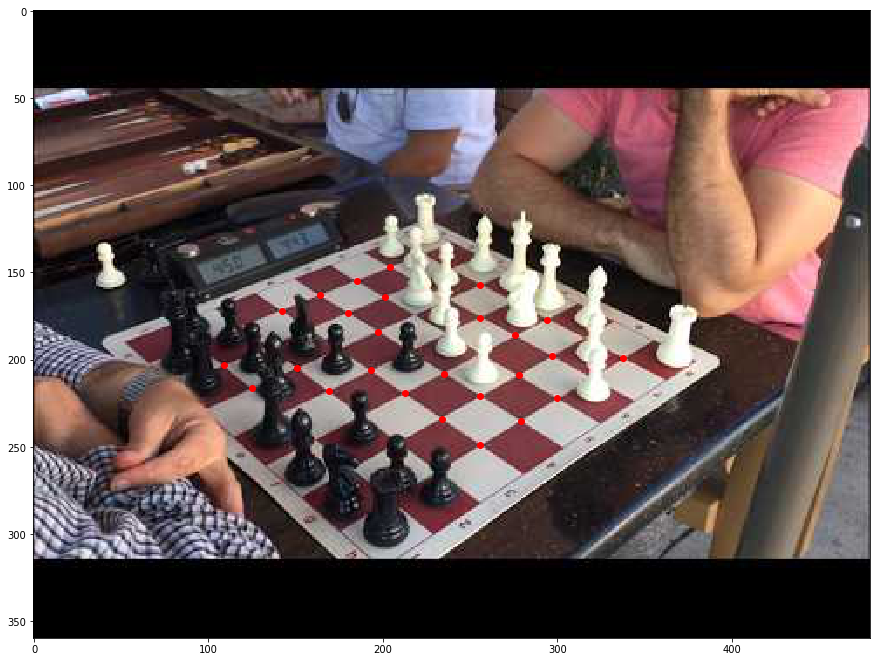

In [1]:
%pylab inline
from IPython.display import Image, display
import PIL.Image
import matplotlib.image as mpimg
import scipy.ndimage
import cv2 # For Sobel etc
import glob
import RunExportedMLOnImage

np.set_printoptions(suppress=True) # Better printing of arrays
plt.rcParams['image.cmap'] = 'jet' # Default colormap is jet

# img = PIL.Image.open('frame900.png')
# img = PIL.Image.open('input/img_35.jpg')
filenames = glob.glob('input_yt/*.jpg')
filenames.extend(glob.glob('input_yt/*.png'))
filenames.extend(glob.glob('input/*.jpg'))
filenames.extend(glob.glob('input/*.png'))
filenames.extend(glob.glob('input_bad/*.png'))
filenames.extend(glob.glob('input_bad/*.jpg'))
print(len(filenames))
filename = np.random.choice(filenames,1)[0]
print(filename)
img = PIL.Image.open(filename)
if (img.size[0] > 800):
    img = img.resize([600,400])
gray = np.array(img.convert('L'))

inlier_pts, outlier_pts, pred_pts, final_predictions, prediction_levels, tri, simplices_mask = RunExportedMLOnImage.processImage(gray)

# pts = np.loadtxt('example_pts.txt')
pts = inlier_pts
pts = pts[:,[1,0]] # Switch rows/cols to x/y for plotting on an image

fig = plt.figure(figsize=(15,15))
plt.imshow(img)
plt.plot(pts[:,0],pts[:,1],'ro');

if (len(inlier_pts)) < 6:
    raise("Probably not enough points for a good fit, skipping")

# RANSAC to find the best 4 points signifying a chess tile.
Idea to find quads from triangles. For each triangle, the triangle that completes the quad should always be on the longest edge of the triangle and shares the two vertices of that edge. No image gradient checks needed.

In [2]:
# Build up a list of quads from input delaunay triangles, returns an Nx4 list of indices on the points used.
def getAllQuads(tri):
    pairings = set()
    quads = []
    # Build up a list of all possible unique quads from triangle neighbor pairings. 
    # In general the worst common case with a fully visible board is 6*6*2=36 triangles, each with 3 neighbor
    # so around ~100 quads.
    for i, neighbors in enumerate(tri.neighbors):
        for k in range(3): # For each potential neighbor (3, one opposing each vertex of triangle)
            nk = neighbors[k]
            if nk != -1:
                # There is a neighbor, create a quad unless it already exists in set
                pair = (i, nk)
                reverse_pair = (nk, i)
                if reverse_pair not in pairings:
                    # New pair, add and create a quad
                    pairings.add(pair)
                    b = tri.simplices[i]
                    d = tri.simplices[nk]                
                    nk_vtx = (set(d) - set(b)).pop()
                    insert_mapping = [2,3,1]
                    b = np.insert(b,insert_mapping[k], nk_vtx)
                    quads.append(b)
    return np.array(quads)

quads = getAllQuads(tri)
print(len(quads))

57


In [3]:
def countHits(given_pts, x_offset, y_offset):
    # Check the given integer points (in unity grid coordinate space) for matches
    # to an ideal chess grid with given initial offsets
    pt_set = set((a,b) for a,b in given_pts)
    [X,Y] = np.meshgrid(np.arange(7) + x_offset,np.arange(7) + y_offset)
    matches = 0
    # count matching points in set
    matches = sum(1 for x,y in zip(X.flatten(), Y.flatten()) if (x,y) in pt_set)
    return matches
        
def getBestBoardMatchup(given_pts):
    best_score = 0
    best_offset = None
    for i in range(7):
        for j in range(7):
            # Offsets from -6 to 0 for both
            score = countHits(given_pts, i-6, j-6)
            if score > best_score:
                best_score = score
                best_offset = [i-6, j-6]
    return best_score, best_offset

In [4]:
def scoreQuad(quad, pts, prevBestScore=0):
    idealQuad = np.array([[0,1],[1,1],[1,0],[0,0]],dtype=np.float32)
    M = cv2.getPerspectiveTransform(quad.astype(np.float32), idealQuad)
    warped_to_ideal = cv2.perspectiveTransform(np.expand_dims(quad.astype(float),0), M)
    # Warp points and score error
    pts_warped = cv2.perspectiveTransform(np.expand_dims(pts.astype(float),0), M)[0,:,:]
    
    # Get their closest idealized grid point
    pts_warped_int = pts_warped.round().astype(int)
    
    # Count matches
    score, offset = getBestBoardMatchup(pts_warped.round().astype(int))
    if score < prevBestScore:
        return score, None, None, None
    
    # Sum of distances from closest integer value for each point
    # Use this error score for tie-breakers where number of matches is the same.
    error_score = np.sum(np.linalg.norm((pts_warped - pts_warped_int), axis=1))
    
    return score, error_score, M, offset

def brutesacChessboard(xcorner_pts):
    # Build a list of quads to try.
    quads = getAllQuads(tri)
    
    # For each quad, keep track of the best fitting chessboard.
    best_score = 0
    best_error_score = None
    best_M = None
    best_quad = None
    best_offset = None
    for quad in xcorner_pts[quads]:
        score, error_score, M, offset = scoreQuad(quad, xcorner_pts, best_score)
        if score > best_score or (score == best_score and error_score < best_error_score):
            best_score = score
            best_error_score = error_score
            best_M = M
            best_quad = quad
            best_offset = offset

    return best_M, best_quad, best_offset, best_score, best_error_score

In [5]:
%%time
best_M, best_quad, best_offset, best_score, best_error_score = brutesacChessboard(pts)
print(best_score, best_error_score)
print(best_M)

(25, 4.959299681345965)
[[ -0.23075736   0.41023531 -20.89636117]
 [ -0.20663866  -0.48215686 120.60809511]
 [ -0.00455528   0.04831199   1.        ]]
CPU times: user 512 ms, sys: 4 ms, total: 516 ms
Wall time: 515 ms


The chess outline is only a rough guess, which we can easily refine now that we have an understanding of which points are meant for which chess corner. One could do distortion correction with the points available (as normal chessboard algorithms are used for in computer vision). If we wanted to get fancy we could apply a warp flow field on a per-tile basis.

## Refine with Homography on all points
Now we can refine our best guess using all the found x-corner points to their ideal points with opencv findHomography, using the regular method with all points.

In [6]:
%%time
pts_warped = cv2.perspectiveTransform(np.expand_dims(pts.astype(float),0), best_M)[0,:,:]
a = pts_warped.round()
b = pts

# Only use points from within chessboard region.
x = a - best_offset
outliers = np.any((x < 0) | (x > 7), axis=1)
a = a[~outliers]
b = b[~outliers]

# Least-Median robust homography
M_homog, _ = cv2.findHomography(b,a, cv2.LMEDS)
print(M_homog)
print(best_M - M_homog)

[[-0.06395711  0.10959978 -5.15727225]
 [-0.05608276 -0.13199849 32.94498979]
 [-0.00020619  0.00768848  1.        ]]
[[ -0.16680025   0.30063554 -15.73908892]
 [ -0.15055589  -0.35015837  87.66310532]
 [ -0.0043491    0.0406235    0.        ]]
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 5.54 ms


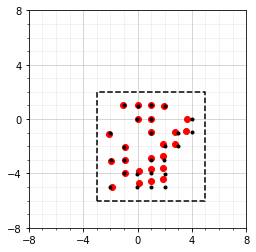

In [7]:
pts_warped2 = cv2.perspectiveTransform(np.expand_dims(pts.astype(float),0), M_homog)[0,:,:]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# Major ticks every 20, minor ticks every 5
major_ticks = np.arange(-8, 9, 4)
minor_ticks = np.arange(-8, 9, 1)

ax.axis('square')
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)

# And a corresponding grid
ax.grid(which='both')

# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)

ideal_grid_pts = np.vstack([np.array([0,0,1,1,0])*8-1+best_offset[0], np.array([0,1,1,0,0])*8-1+best_offset[1]]).T

plt.plot(ideal_grid_pts[:,0], ideal_grid_pts[:,1], 'k--')
plt.plot(pts_warped[:,0], pts_warped[:,1], 'ro')
plt.plot(pts_warped2[:,0], pts_warped2[:,1], 'k.')

plt.show()

In [12]:
unwarped_ideal_chess_corners.astype(int).shape

(5, 2)

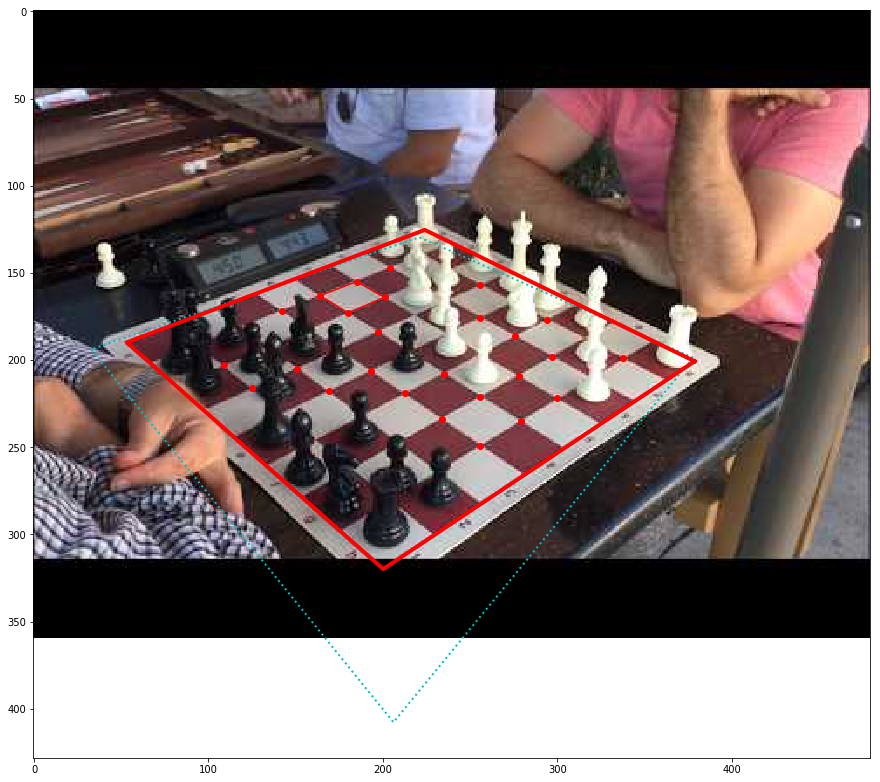

In [8]:
fig = plt.figure(figsize=(15,15))
plt.imshow(img)
plt.plot(pts[:,0], pts[:,1], 'ro')
plt.plot(best_quad[[0,1,2,3,0],0], best_quad[[0,1,2,3,0],1],'r.-');

# Plot un-refined chessboard outline guess onto image.
unwarped_ideal_chess_corners = cv2.perspectiveTransform(
    np.expand_dims(ideal_grid_pts.astype(float),0), np.linalg.inv(best_M))[0,:,:]

plt.plot(unwarped_ideal_chess_corners[:,0], unwarped_ideal_chess_corners[:,1], 'c:', lw=2);

# Refined via homography of all valid points
unwarped_ideal_chess_corners_homography = cv2.perspectiveTransform(
    np.expand_dims(ideal_grid_pts.astype(float),0), np.linalg.inv(M_homog))[0,:,:]

plt.plot(unwarped_ideal_chess_corners_homography[:,0], unwarped_ideal_chess_corners_homography[:,1], 'r-', lw=4);

# Unused

The following cells involve an idea to find outlier points where their triangles have edge lengths that deviate far from the median triangle edge length. This assumes most points are chess x-corner points (true after ML algorithm), and therefore the triangles found will be of edge lengths around that of a tile.

In practice we don't need this, as the following cells of fitting the points to a 7x7 grid does a better job of finding the true points, taking advantage of the fact that chessboard x-corners must fit in a 7x7 grid with uniform spacing.